In [5]:
!pip install shap > None

In [6]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_blobs
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

from xgboost import XGBRegressor

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import shap

import warnings
warnings.simplefilter('ignore')

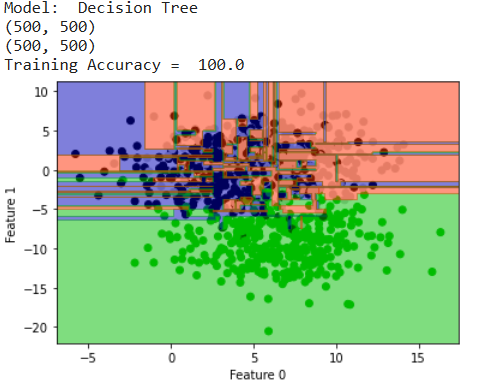

## Ансамблирование моделей 

Техника для улучшения качества предсказаний. Основная идея заключается в том, что отдельно обучаются несколько моделей, а далее их предсказания комбинируются.

**Почему это работает?**

Основной принцип - создать максимально разнообразный ансамбль, чтобы ошибки одних алгоритмов на отдельных объектах будут компенсировались корректной работой других алгоритмов

### Подготовка данных + LinearRegression

In [7]:
data = pd.read_csv('abalone.data.txt', header=None)
data.columns = ['sex', 'length', 'diameter', 'height', 'whole_weight', 'hucked_weight', 'viscera_weight', 'shell_weight', 'rings']
data.head()

,sex,length,diameter,height,whole_weight,hucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [8]:
res = pd.get_dummies(data['sex'], prefix='sex', drop_first=True)
data = pd.concat([data, res], axis=1).drop(columns='sex')

In [9]:
corrs = data.corr()
upper_tri = corrs.where(np.triu(np.ones(corrs.shape), k=1).astype(np.bool))
cols_to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
cutted_data = data.drop(columns=cols_to_drop)
cutted_data.head()

,length,height,whole_weight,rings,sex_I,sex_M
0,0.455,0.095,0.5140,15,0,1
1,0.350,0.090,0.2255,7,0,1
2,0.530,0.135,0.6770,9,0,0
3,0.440,0.125,0.5160,10,0,1
4,0.330,0.080,0.2050,7,1,0


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    cutted_data.drop(columns='rings'),
    cutted_data['rings'], 
    random_state=2023, 
    test_size=0.3
)

In [11]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

In [12]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_preds_lr = lr.predict(X_test_scaled)

In [13]:
print(f'RMSE: {mean_squared_error(y_test, y_preds_lr, squared=False)}')

RMSE: 2.5041378689818625


### Простое усреднение

In [14]:
models = [LinearRegression(), Ridge(), KNeighborsRegressor()]
preds = []
for model in models:
  model.fit(X_train_scaled, y_train)
  preds.append(model.predict(X_test_scaled))
y_preds = np.array(preds).mean(axis=0)
print(f'RMSE: {mean_squared_error(y_test, y_preds, squared=False)}')

RMSE: 2.4803732019250906


### Бэггинг

**Bagging (Bootstrap aggregating)**






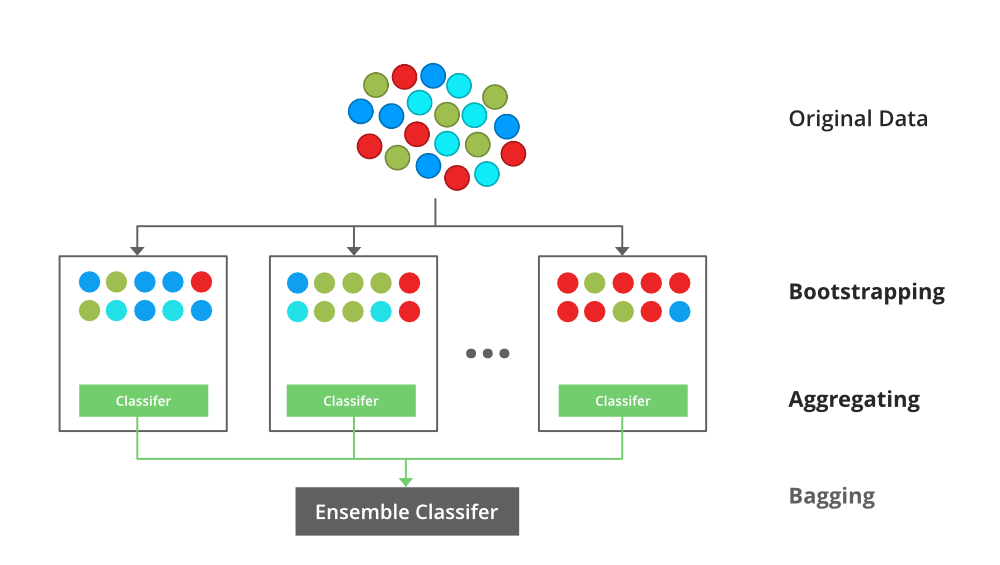

Если k базовых алгоритмов некоррелированы, то можно показать, что дисперсия композиции в k раз меньше дисперсии отдельного алгоритма

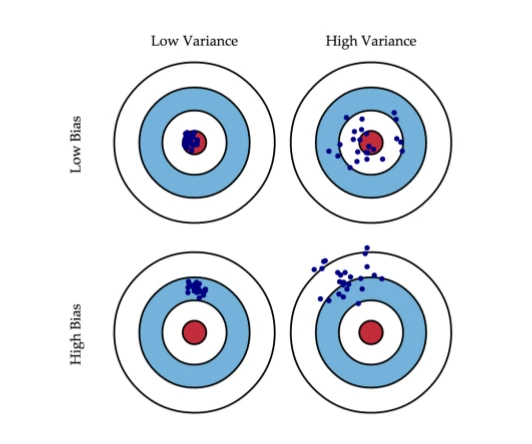

#### BaggingRegressor

In [15]:
bagging_model = BaggingRegressor(
    base_estimator=LinearRegression(),
    n_estimators=10,
    random_state=2023,
).fit(X_train_scaled, y_train)
y_preds = bagging_model.predict(X_test_scaled)
print(f'RMSE: {mean_squared_error(y_test, y_preds, squared=False)}')

RMSE: 2.482443526341356


#### Случайный лес

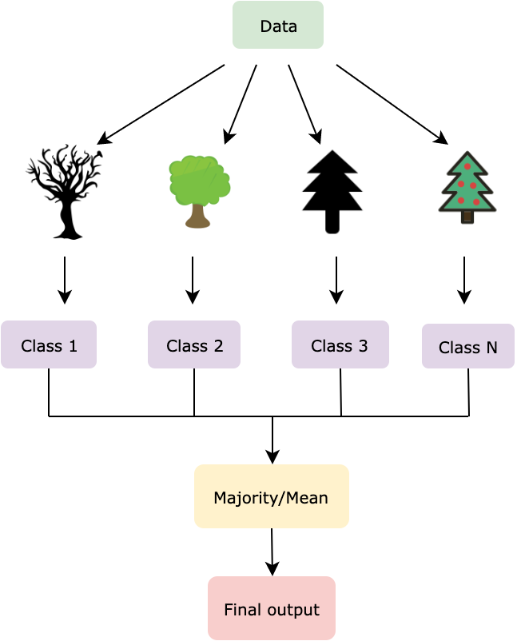

In [16]:
rf = RandomForestRegressor(random_state=2023)
rf.fit(X_train_scaled, y_train)
y_preds = rf.predict(X_test_scaled)
print(f'RMSE: {mean_squared_error(y_test, y_preds, squared=False)}')

RMSE: 2.6338367219275174


In [17]:
parameters = {
    'n_estimators': np.arange(50, 160, 20),
    'max_depth': list(range(3, 11)) + [None],
    'random_state': [2023],
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=parameters,
    n_jobs=2,
    verbose=1,
    cv=3,
)

In [18]:
%%time

grid_search.fit(X_train_scaled, y_train)

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits
max_depth: 5
n_estimators: 130
random_state: 2023
CPU times: user 1.19 s, sys: 142 ms, total: 1.33 s
Wall time: 57 s


In [19]:
y_preds = grid_search.best_estimator_.predict(X_test_scaled)
print(f'RMSE: {mean_squared_error(y_test, y_preds, squared=False)}')

RMSE: 2.4353327999575307


### Бустинг

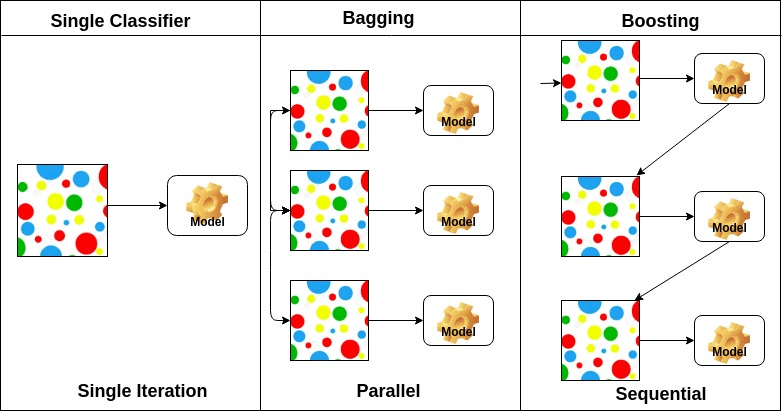

In [20]:
model = XGBRegressor()
parameters = {
  'learning_rate': np.linspace(0.01, 1, 5), 
  'max_depth': list(range(3, 10)),
  'subsample': np.linspace(0.7, 0.9, 5),
  'colsample_bytree': np.linspace(0.5, 0.98, 5),
  'n_estimators': np.arange(50, 300, 10), 
  'seed': [2023]
}

xgb_random_search = RandomizedSearchCV(
    model, 
    parameters,
    n_jobs=5, 
    cv=5, 
    scoring='neg_mean_squared_error',
    verbose=2, 
    refit=True
)
xgb_random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[12:26:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, estimator=XGBRegressor(), n_jobs=5,
                   param_distributions={'colsample_bytree': array([0.5 , 0.62, 0.74, 0.86, 0.98]),
                                        'learning_rate': array([0.01  , 0.2575, 0.505 , 0.7525, 1.    ]),
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9],
                                        'n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170,
       180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290]),
                                        'seed': [2023],
                                        'subsample': array([0.7 , 0.75, 0.8 , 0.85, 0.9 ])},
                   scoring='neg_mean_squared_error', verbose=2)

In [21]:
y_preds = xgb_random_search.best_estimator_.predict(X_test_scaled)
print(f'RMSE: {mean_squared_error(y_test, y_preds, squared=False)}')

RMSE: 2.577298473551272


#### Другие библиотеки с градиентным бустингом...

**XGBoost**

[Документация](https://xgboost.readthedocs.io/en/stable/)


Некоторые фичи:
- Level-wise growth, затем прунинг вершин


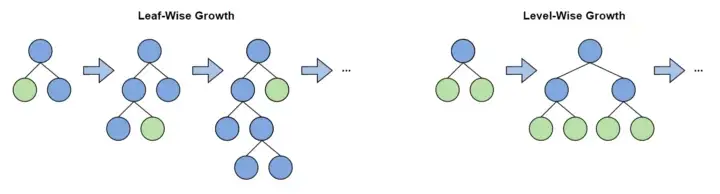

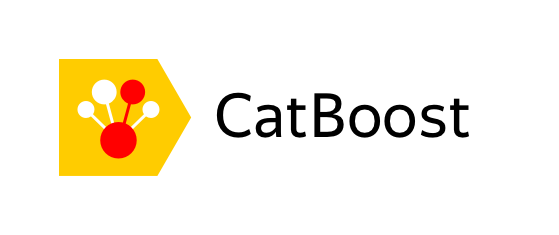

[Документация](https://catboost.ai/)

Некоторые фичи:


- Сначала выбираются параметры для разбиения, потом строится дерево
- Симметричные деревья для скорости
- Ordered target encoding
- Поддержка текстовых признаков



**LightGBM**

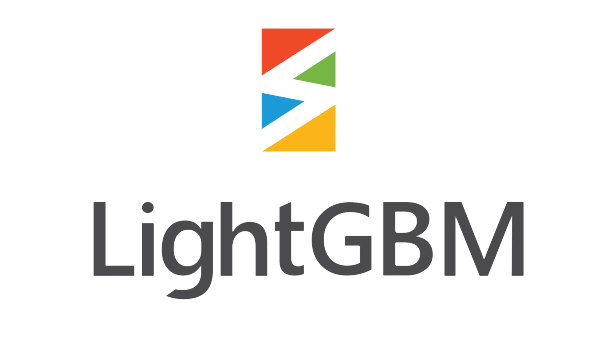

[Документация](https://lightgbm.readthedocs.io/en/latest/index.html)

Некоторые фичи:

- List-wise growth
- Обучение на всех объектах с большой ошибкой, с маленькой - сэмплируются 
- Встроенная кодировка категориальных признаков, которая лучше OHE

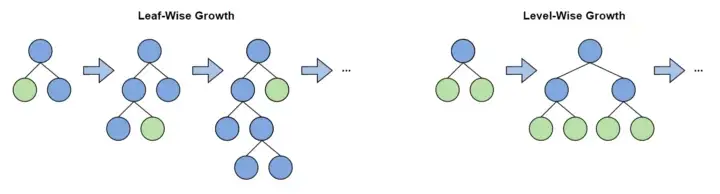

### Стэкинг

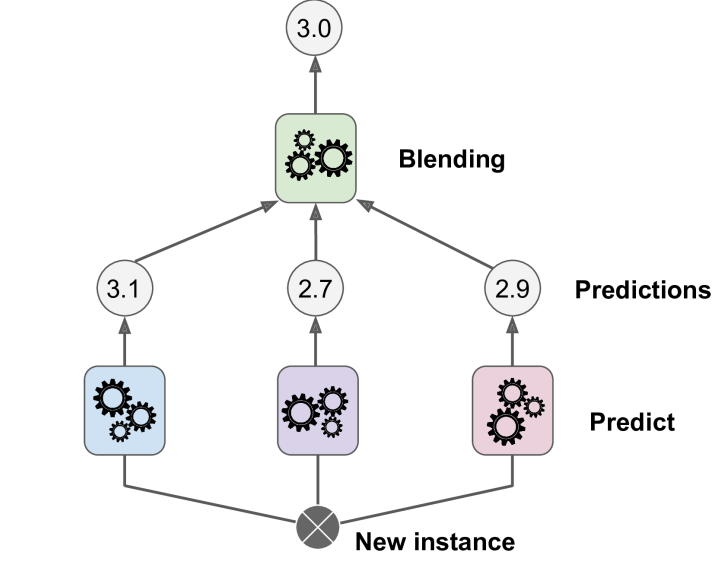

In [22]:
X_train_short, X_valid_short, y_train_short, y_valid_short = train_test_split(X_train_scaled, y_train, test_size=0.25, random_state=2023)

In [23]:
def run(model):
    model.fit(X_train_short, y_train_short)
    preds = model.predict(X_valid_short)
    print(model.__class__.__name__ + ' rmse  = ' + str(mean_squared_error(y_valid_short,  preds)))
    return model

In [25]:
class Stacking(BaseEstimator, RegressorMixin):  
    def __init__(self, models, meta_model):
        self.models = models
        self.meta_model = meta_model
        self.n = len(models)
        self.valid = None
        
    def fit(self, X, y=None):
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=2023)
        self.valid = np.zeros((X_valid.shape[0], self.n))

        for i, model in enumerate(self.models):
            model.fit(X_train, y_train)
            self.valid[:, i] = model.predict(X_valid)
        self.meta_model.fit(self.valid, y_valid)  
        return self

    def predict(self, X, y=None):
        X_meta = np.zeros((X.shape[0], self.n))
        
        for i, model in enumerate(self.models):
            X_meta[:, i] = model.predict(X)

        return self.meta_model.predict(X_meta)

In [26]:
models = [Ridge(), LinearRegression(), KNeighborsRegressor(), RandomForestRegressor(), XGBRegressor(objective='reg:squarederror')]
for model in models:
  run(model)

Ridge rmse  = 9.103202194242568
LinearRegression rmse  = 9.115190154866774
KNeighborsRegressor rmse  = 7.733023255813953
RandomForestRegressor rmse  = 7.569200034199726
XGBRegressor rmse  = 6.791131350517489


In [27]:
%%time

meta_model = LinearRegression()

stack_model = Stacking(models, meta_model)
stack_model.fit(X_train_scaled, y_train)
preds = stack_model.predict(X_test)
print(mean_squared_error(y_test, preds, squared=False))

3.1021661670949383
CPU times: user 1.11 s, sys: 44.8 ms, total: 1.15 s
Wall time: 1.55 s


## Интерпретация моделей

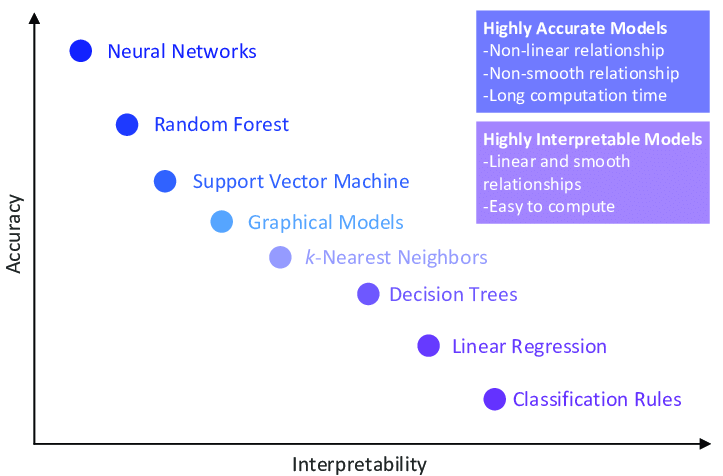

In [28]:
rf = RandomForestRegressor(random_state=2023)
rf.fit(X_train_scaled, y_train)
y_preds = rf.predict(X_test_scaled)
print(f'RMSE: {mean_squared_error(y_test, y_preds, squared=False)}')

RMSE: 2.6338367219275174


#### Mean Decrease Impurity

Основывается на среднем уменьшении информационного критерия при разбиении.

Числовые признаки и категориальные признаки с высокой кардинальностью ранжируются как более важные

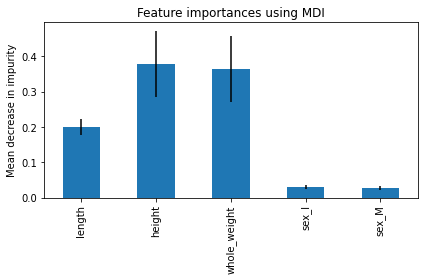

In [29]:
forest_importances = pd.Series(rf.feature_importances_, index=X_train.columns)

fig, ax = plt.subplots()
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity", )
fig.tight_layout()

#### Permutation importances

Случайным образом перемешиваем данные по одному признаку за раз и смотрим на изменение целевой метрики


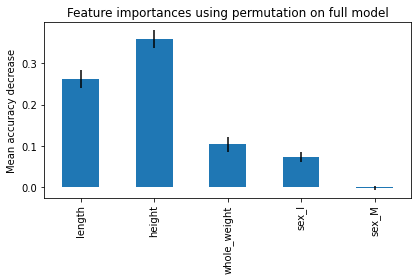

In [30]:
importances = permutation_importance(rf, X_test_scaled, y_test, n_repeats=10, random_state=2023, n_jobs=2)
forest_importances = pd.Series(importances.importances_mean, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=importances.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

#### SHAP

[Документация](https://shap.readthedocs.io/en/latest/)

In [31]:
explainer = shap.TreeExplainer(rf)

In [32]:
choosen_instance = X_test_scaled.loc[[10]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

Summary plot

- Каждая горизонтальная линия соответствует одному признаку
- Отдельные точки соответствуют тестовым примерам
- Кордината точки по X - SHAP value
- Цвет точки - значение признака

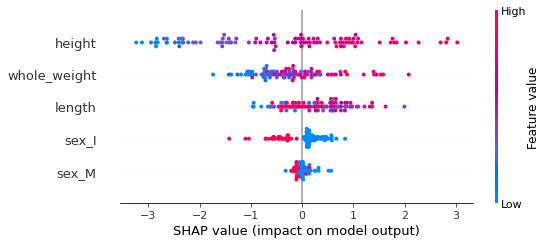

In [33]:
shap_values = explainer.shap_values(X_train_scaled.iloc[:100])
shap.summary_plot(shap_values, X_train_scaled.iloc[:100])

## Калибровка

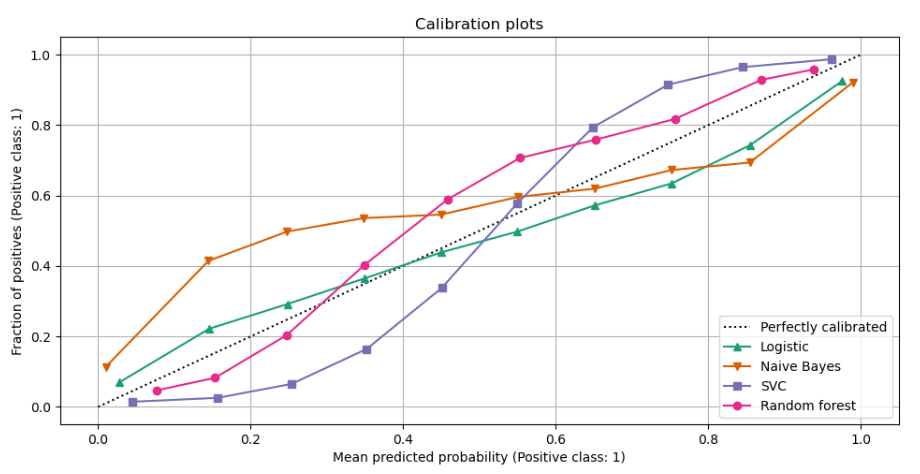

In [35]:
np.random.seed(2023)

X, y = make_blobs(n_samples=20000, n_features=2, centers=2, random_state=2023, cluster_std=10.0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=2023, test_size=0.25)

In [36]:
clf_list = [RandomForestClassifier(random_state=2023), LogisticRegression()]

In [37]:
def plot_probability_curves(do_calibration=False):
  fig = plt.figure(figsize=(10, 10))
  gs = GridSpec(4, 2)
  colors = plt.cm.get_cmap("Dark2")

  ax_calibration_curve = fig.add_subplot(gs[:2, :2])
  calibration_displays = {}
  for i, clf in enumerate(clf_list):
    name = clf.__class__.__name__
    if do_calibration:
      clf = CalibratedClassifierCV(clf, cv="prefit", method='isotonic')
      clf.fit(X_valid, y_valid)
    else:
      clf.fit(X_train, y_train)

    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

  ax_calibration_curve.grid()
  ax_calibration_curve.set_title("Calibration plots")

  plt.tight_layout()
  plt.show()

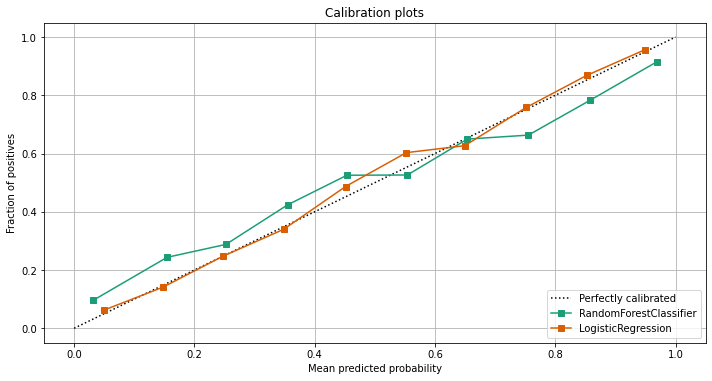

In [38]:
plot_probability_curves(do_calibration=False)

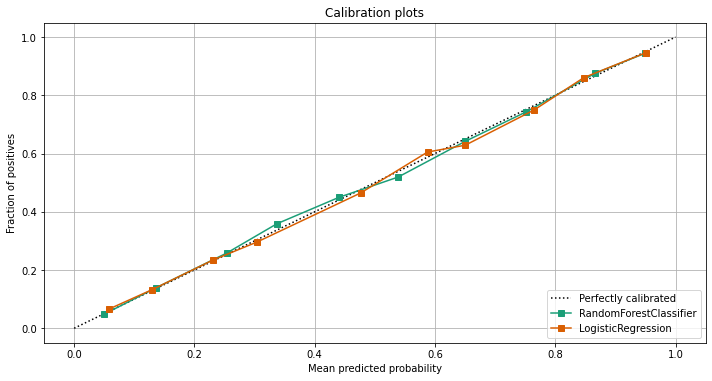

In [39]:
plot_probability_curves(do_calibration=True)